# Reaction Diffusion - 2D
$$ \frac{\partial\phi}{\partial t} - \nabla\cdot (D \nabla \phi) = \alpha\phi(1-\phi)$$

Where: 
$$ \phi = \textrm{Tumor volume fraction or number of tumor cells} $$

And parameters $D$ and $\alpha$ can be functions of a deformation measure:
\begin{align*}
D &= \overline{D}\exp(-\gamma^{Pa}J) \\
\alpha &= \overline{\alpha}\exp(-\gamma^{mob}J)
\end{align*}

Since $D$ may be a function of space, the form can be rewritten:
$$ \frac{\partial\phi}{\partial t} - \nabla D \cdot \nabla \phi - D \nabla\cdot\nabla \phi = \alpha\phi(1-\phi)$$
$$ \frac{\partial\phi}{\partial t} - \nabla D \cdot \nabla \phi - D \nabla^2 \phi = \alpha\phi(1-\phi)$$

Discretization of time derivative by FDM, backward Euler:
\begin{align*}
\frac{\phi^{n+1}-\phi^n}{\Delta t} - \nabla D \cdot \nabla \phi^{n+1} - D \nabla^2 \phi^{n+1} - \alpha\phi^{n+1}(1-\phi^{n+1}) &= 0 \\
\phi^{n+1}-\phi^n + \Delta t \left[-\nabla D \cdot \nabla \phi^{n+1} - D \nabla^2 \phi^{n+1} - \alpha\phi^{n+1}(1-\phi^{n+1})\right] &= 0 
\end{align*}

Variational formulation: multiply by test function and integrate second-order terms:
$$ \int_{\Omega} \left(\phi^{n+1}-\phi^n \right)v + \Delta t \left[ -(\nabla D \cdot \nabla \phi^{n+1})v - (D \nabla^2 \phi^{n+1})v - \alpha\phi^{n+1}(1-\phi^{n+1})v \right] \,d\mathbf{x} = 0 $$

Using Green's first identity, 
\begin{align*}
- \int_\Omega Dv\nabla^2\phi^{n+1} \,dx &= \int_\Omega \nabla(Dv)\cdot\nabla\phi^{n+1} \,dx - \int_{\Gamma} Dv(\nabla \phi^{n+1} \cdot \mathbf{n})\,d\Gamma \\
&= \int_\Omega (D\nabla v + v\nabla D)\cdot\nabla\phi^{n+1} \,dx - \int_{\Gamma} Dv(\nabla \phi^{n+1} \cdot \mathbf{n})\,d\Gamma
\end{align*}

Thus,
$$ \int_{\Omega} \left(\phi^{n+1}-\phi^n \right)v + \Delta t \left[ -(\nabla D \cdot \nabla \phi^{n+1})v + (D\nabla v + v\nabla D)\cdot\nabla\phi^{n+1} - \alpha\phi^{n+1}(1-\phi^{n+1})v \right] \,d\mathbf{x} - \int_{\Gamma} \Delta t Dv(\nabla \phi^{n+1} \cdot \mathbf{n})\,d\Gamma = 0 $$
$$ \int_{\Omega} \left(\phi^{n+1}-\phi^n \right)v + \Delta t \left[ D\nabla v\cdot\nabla\phi^{n+1} - \alpha\phi^{n+1}(1-\phi^{n+1})v \right] \,d\mathbf{x} - \int_{\Gamma} \Delta t Dv(\nabla \phi^{n+1} \cdot \mathbf{n})\,d\Gamma = 0 $$

If we assume homogeneous Neumann boundary conditions for the entire boundary, i.e. $\frac{\partial \phi}{\partial n} = 0$, the boundary terms vanish. For Fenics, let all $n+1$ terms be unlabeled. 

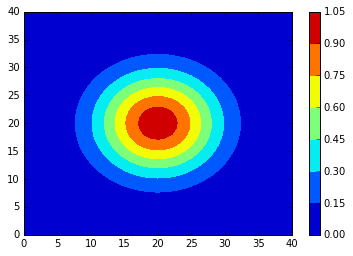

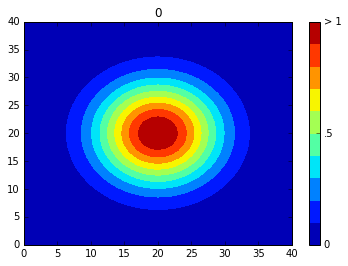

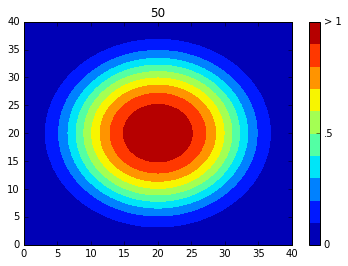

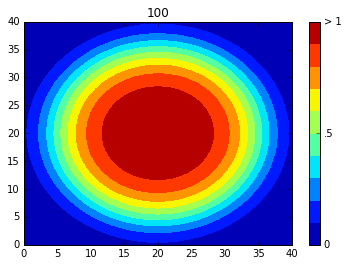

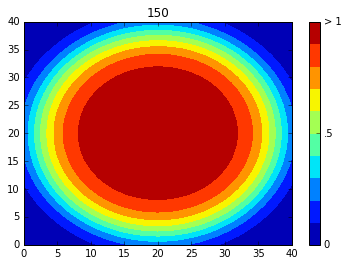

In [2]:
## Reaction Diffusion Formulation in 2D

%matplotlib inline
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
import time
import os

T = 2.0            # final time
num_steps = 200     # number of time steps
dt = T / num_steps # time step size

# Create mesh (3D BOX) and define function space
nx = ny = 40
mesh = RectangleMesh(Point(0, 0), Point(1,1), nx, ny)
V = FunctionSpace(mesh, 'P', 1) # 'P' = 'Lagrange'
                                # P1 = linear triangle

# Define initial value
phi_0 = Expression('exp(-a*pow(x[0]-.5, 2) - a*pow(x[1]-.5, 2) )', 
                 degree=2, a=20)
phi_n = interpolate(phi_0, V)
plt.figure()
f = plt.contourf(phi_n.compute_vertex_values().reshape([nx+1,ny+1]))
plt.colorbar(mappable=f)

# Define expressions used in variational forms
D0 = Constant(.05)
D = Expression('D0/2*(pow(x[0]/100,2) + pow(x[1]/100,2))', 
                 degree=2, D0=D0)         # Parameter 1
D = interpolate(D, V)
alpha = Constant(5)         # Parameter 2
k = Constant(dt)

# Define variational problem
phi = Function(V)
v = TestFunction(V)
f = Constant(0)

F = (phi - phi_n)*v*dx \
    + k*D*dot(grad(v),grad(phi))*dx \
    - k*alpha*phi*(1 - phi)*v*dx 

# Create VTK files for visualization output
os.system('rm ./rd/*')
phifile = XDMFFile('rd/phi.xdmf')
phi.rename("phi","")
t = 0.0
for n in range(num_steps):
    
    # Update current time
    t += dt

    # Solve variational problem for time step
    solve(F == 0, phi)
    
    # Save solution to file (VTK)
    phifile.write(phi,t)
    
    # Update previous solution
    phi_n.assign(phi)
    phiarray = phi_n.compute_vertex_values().reshape([nx+1,ny+1])
    
    if n % 50 == 0:
        fig, ax = plt.subplots()
        cax = ax.contourf(phiarray,np.linspace(0,1,11))
        ax.set_title(str(n))
        cbar = fig.colorbar(cax,ticks=[0,.5,1],spacing='proportional')
        cbar.set_ticklabels(['0', '.5', '> 1'])  # vertically oriented colorbar
        plt.show()

del phifile      

## Test:
The following solution:
$$\phi(x,t) = \frac{1}{\left(1+\exp(c^{1/2}(x-Ut))\right)^2} $$

Where $U = \frac{y}{c^{1/2}}$ and $c = \frac{\alpha}{zD}$. The above formulation with this solution is:
\begin{align*}
\frac{\partial\phi}{\partial t} &= \frac{2c^{1/2}U\exp(c^{1/2}(x-Ut))}{\left(1+\exp(c^{1/2}(x-Ut))\right)^3} \\
\frac{\partial\phi}{\partial x} &= \frac{-2c^{1/2}\exp(c^{1/2}(x-Ut))}{\left(1+\exp(c^{1/2}(x-Ut))\right)^3} \\
\frac{\partial^2\phi}{\partial x^2} &= \frac{6c\exp(2c^{1/2}(x-Ut))}{\left(1+\exp(c^{1/2}(x-Ut))\right)^4} - \frac{2c\exp(c^{1/2}(x-Ut))}{\left(1+\exp(c^{1/2}(x-Ut))\right)^3} \\
\phi\alpha(1-\phi) &= \frac{\alpha}{\left(1+\exp(c^{1/2}(x-Ut))\right)^2} - \frac{\alpha}{\left(1+\exp(c^{1/2}(x-Ut))\right)^4} 
\end{align*}

Putting everything together and substituting for $U$ and $c$:

$$ 2y\exp(c^{1/2}(x-Ut))\left(1+\exp(c^{1/2}(x-Ut))\right) - \frac{6}{z}\alpha\exp(2c^{1/2}(x-Ut)) + \frac{2}{z}\alpha\exp(c^{1/2}(x-Ut))\left(1+\exp(c^{1/2}(x-Ut))\right) = \alpha\left(1+\exp(c^{1/2}(x-Ut))\right)^2 - \alpha $$
$$2y\exp(c^{1/2}(x-Ut)) + 26\exp(2c^{1/2}(x-Ut)) - \frac{6}{z}\alpha\exp(2c^{1/2}(x-Ut)) + \frac{2}{z}\alpha\exp(c^{1/2}(x-Ut))+ \frac{2}{z}\alpha\exp(2c^{1/2}(x-Ut)) = 2\alpha\exp(c^{1/2}(x-Ut)) + \alpha\exp(2c^{1/2}(x-Ut))$$
$$(2y+\frac{2}{z}\alpha-2\alpha)\exp(c^{1/2}(x-Ut)) + (2y-\frac{6}{z}\alpha+\frac{2}{z}\alpha-\alpha)\exp(2c^{1/2}(x-Ut)) = 0$$
The final result is $z = 6$, $\alpha = \frac{6}{5}y$

              Calling FFC just-in-time (JIT) compiler, this may take some time.
              Calling FFC just-in-time (JIT) compiler, this may take some time.


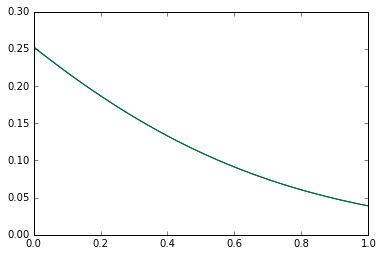

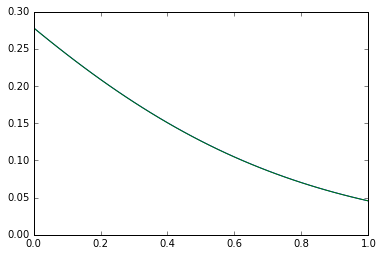

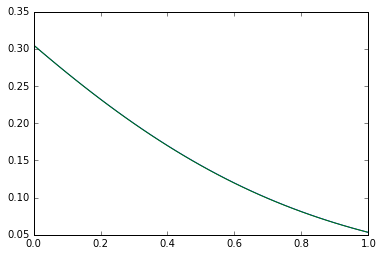

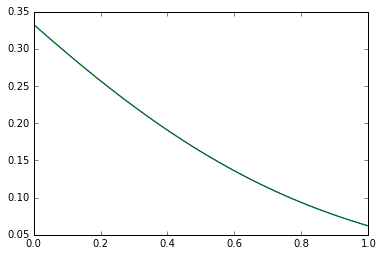

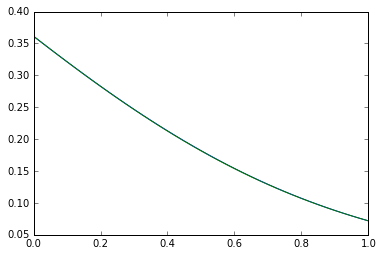

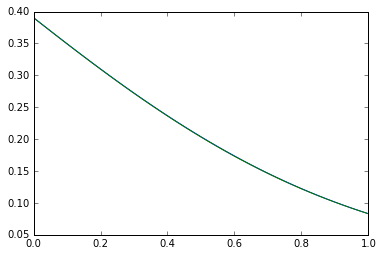

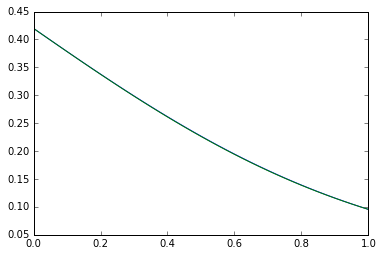

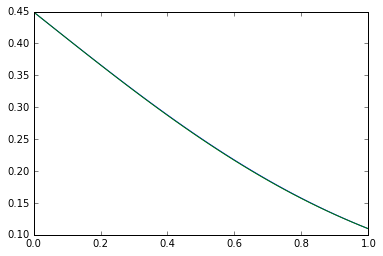

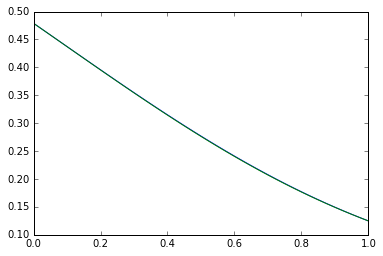

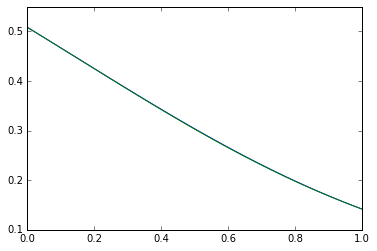

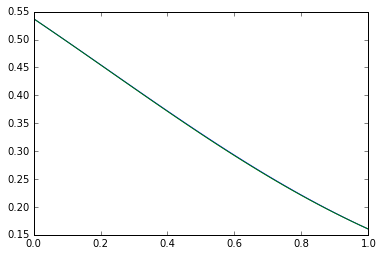

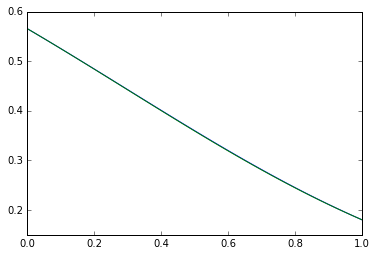

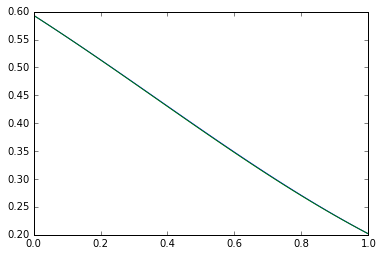

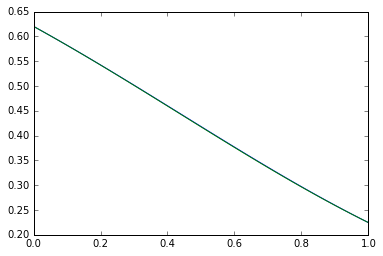

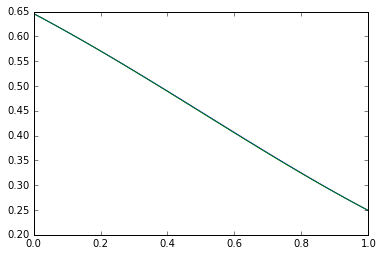

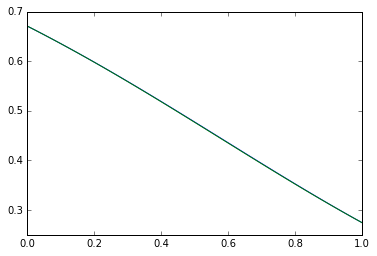

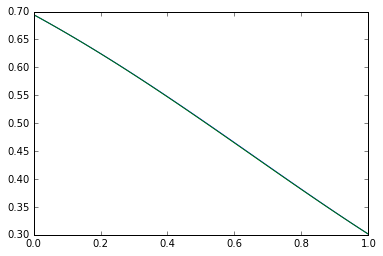

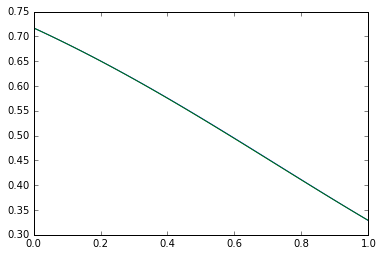

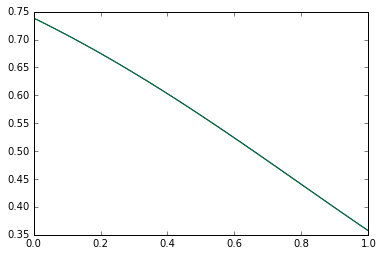

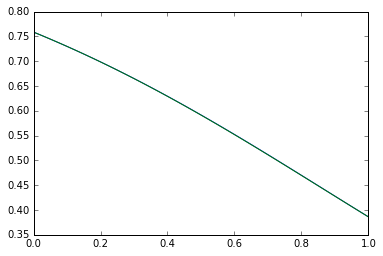

In [246]:
## Reaction Diffusion Formulation in 2D

%matplotlib inline
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
import time

T = 2.0            # final time
num_steps = 200     # number of time steps
dt = T / num_steps # time step size
D = .1
z = 6.
y = 1
alpha = 6./5.*y
c = alpha/z/D
U = y/sqrt(c)

# Create mesh (3D BOX) and define function space
mesh = UnitIntervalMesh(40)
V = FunctionSpace(mesh, 'P', 1) # 'P' = 'Lagrange'

# Define initial value
phi_D = Expression('1/pow((1+exp(sqrt(c)*(x[0]-U*t))),2)', 
                 degree=2, c=c, U=U, t=0)
phi_n = interpolate(phi_D, V)

def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, phi_D, boundary)

# Define expressions used in variational forms
k = Constant(dt)
phi = Function(V)
v = TestFunction(V)
F = (phi - phi_n)*v*dx \
    + k*D*dot(grad(v),grad(phi))*dx \
    - k*alpha*phi*(1 - phi)*v*dx 

# Create VTK files for visualization output
os.system('rm ./rd/*')
phifile = XDMFFile('rd/phi.xdmf')
phi.rename("phi","")
t = 0.0
for n in range(num_steps):
    
    # Update current time
    t += dt
    phi_D.t = t

    # Solve variational problem for time step
    solve(F == 0, phi, bc)
    
    # Save solution to file (VTK)
    phifile.write(phi,t)
    
#     # Compute error at vertices
    phi_e = interpolate(phi_D, V)
#     error = np.abs(phi_e.vector().array() - phi.vector().array()).max()
#     print('t = %.2f: error = %.3g' % (t, error))
    
    # Update previous solution
    phi_n.assign(phi)
    
    if n % 10 == 0:
        fig, ax = plt.subplots()
        plot(phi_n)
        plot(phi_e)

del phifile

# 3D - INCOMPLETE (NEEDS UPDATES FROM TEST AND REFORMULATION)

In [ ]:
%matplotlib inline
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
import time

T = 2.0            # final time
num_steps = 50     # number of time steps
dt = T / num_steps # time step size

# Create mesh (3D BOX) and define function space
nx = ny = nz = 20
mesh = BoxMesh(Point(-2, -2, -2), Point(2, 2, 2), nx, ny, nz)
V = FunctionSpace(mesh, 'P', 1) # 'P' = 'Lagrange'
                                # P1 = linear triangle

# Define initial value
phi_0 = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2) - a*pow(x[2], 2) )', 
                 degree=2, a=5)
phi_n = interpolate(phi_0, V)

# Define expressions used in variational forms
D = Constant(100.0)             # Parameter 1
alpha = Constant(1.0)         # Parameter 2
k = Constant(dt)

# Define variational problem
phi = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

F = (phi - phi_n)*v*dx + D*dot(grad(phi),grad(v))*dx*k - alpha*phi*(1 - phi)*v*dx*k 
a, L = lhs(F), rhs(F)

# Create VTK files for visualization output
vtkfile_phi = File('rd/solution.pvd')

phi = Function(V)
t = 0
for n in range(num_steps):
    
    # Update current time
    t += dt

    # Solve variational problem for time step
    solve(a == L, phi)
    
    # Save solution to file (VTK)
    vtkfile_phi << (phi,t)
    
    # Update previous solution
    phi_n.assign(phi)
    
    #f1 = plt.figure()
    #plot(phi)